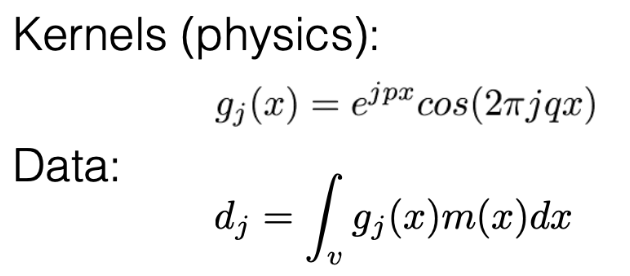

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.sparse as sp

In [9]:
def kernel_function(x, j, p, q): 
    return (
        np.exp(j * p * x) 
        * np.cos(2 * np.pi * j * q * x) 
    )

In [79]:
n_cells = 20
x_nodes = np.linspace(0, 1, n_cells+1)

In [80]:
n_kernels = 20 

p = -0.25
q = 0.25
j0 = 1
jN = 60

j_values = np.linspace(j0, jN, n_kernels)

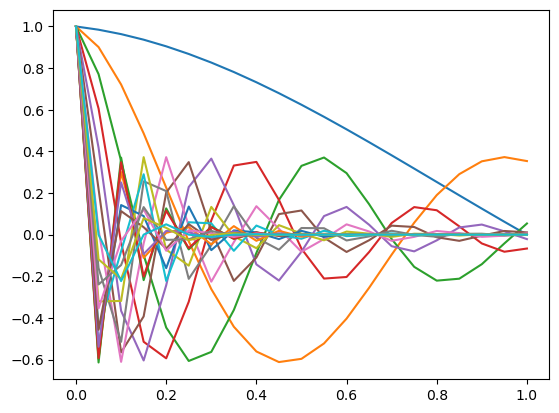

In [81]:
for jk in j_values: 
    g = kernel_function(x_nodes, j=jk, p=p, q=q)
    plt.plot(x_nodes, g)

In [82]:
delta_x = np.diff(x_nodes) #x_nodes[1:] - x_nodes[:-1]
x_centers = x_nodes[:-1] + delta_x / 2

(0.0, 0.1)

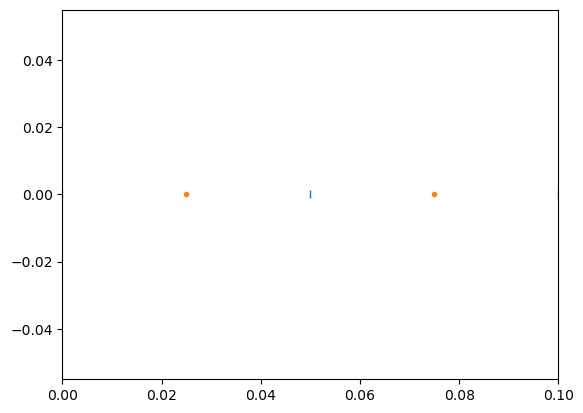

In [83]:
fig, ax = plt.subplots(1, 1)

ax.plot(x_nodes, np.zeros_like(x_nodes), "|")
ax.plot(x_centers, np.zeros_like(x_centers), ".")
ax.set_xlim([0, 0.1])

## define our model 
- boxcar and a gaussian 

In [84]:
model = np.zeros_like(x_centers) 

x_boxcar = np.r_[0.15, 0.25]
amplitude_boxcar = 0.5

inds_boxcar = (x_centers > x_boxcar.min()) & (x_centers < x_boxcar.max())
model[inds_boxcar] = amplitude_boxcar

def gaussian(x, x0, sigma): 
    return np.exp( - (x-x0)**2 / (2 * sigma**2))

x0_gaussian = 0.6
sigma = 0.05 
amplitude = 0.4 

model = model + amplitude * gaussian(x_centers, x0_gaussian, sigma) 

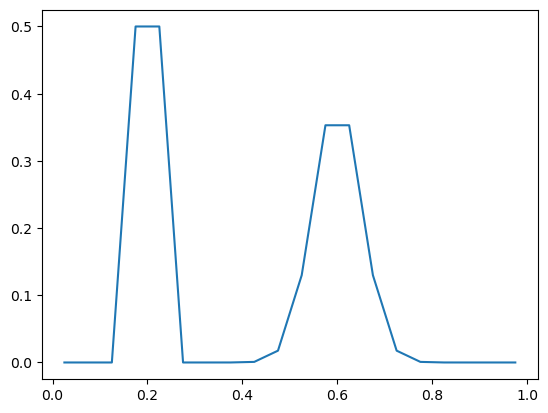

In [85]:
plt.plot(x_centers, model)

In [86]:
len(model)

20

In [87]:
len(g)

21

In [88]:
g0 = kernel_function(x_nodes, j_values[0], p, q)

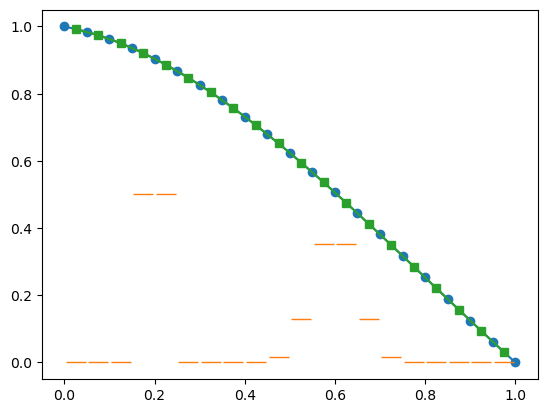

In [97]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_nodes, g0, "-o")
ax.plot(x_centers, model, "_", ms=14)
# ax.plot(x_centers, g_centers, "-s")

In [96]:
g_centers = (g0[1:] + g0[:-1])/2

In [101]:
n_nodes = len(x_nodes)
n_centers = len(x_centers) 

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.]])

In [102]:
ave = sp.spdiags(0.5*np.vstack([np.ones(n_nodes), np.ones(n_nodes)]), [0, 1],m=n_centers, n=n_nodes)

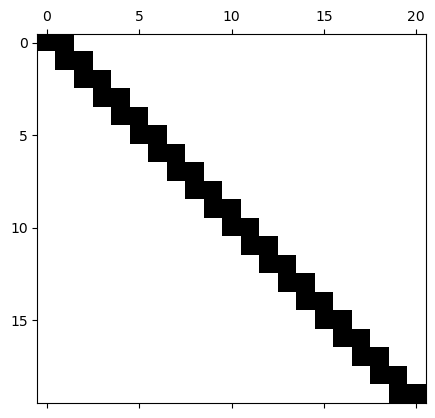

In [106]:
plt.spy(ave.todense())

In [107]:
g0.shape

(21,)

In [108]:
ave.shape

(20, 21)

In [109]:
g_centers2 = ave @ g0

In [110]:
g_centers2

array([0.99226671, 0.97391783, 0.94994175, 0.92062711, 0.88628872,
       0.847265  , 0.80391525, 0.75661693, 0.7057628 , 0.65175815,
       0.59501791, 0.53596387, 0.47502182, 0.41261885, 0.34918061,
       0.28512871, 0.22087819, 0.15683506, 0.09339403, 0.0309363 ])

In [111]:
g_centers

array([0.99226671, 0.97391783, 0.94994175, 0.92062711, 0.88628872,
       0.847265  , 0.80391525, 0.75661693, 0.7057628 , 0.65175815,
       0.59501791, 0.53596387, 0.47502182, 0.41261885, 0.34918061,
       0.28512871, 0.22087819, 0.15683506, 0.09339403, 0.0309363 ])